<a href="https://colab.research.google.com/github/Bhavesh16/Memes-vs-Notes/blob/master/Memes_vs_Notes(FC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import sklearn
from sklearn.model_selection import train_test_split

In [5]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    
    return A, cache

def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ
    

def sigmoid_backward(dA, cache):

    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [6]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

In [7]:
def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [9]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) //2                # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation = "relu") 
        caches.append(cache)
        
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [11]:
def linear_backward(dZ, cache):
 
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [12]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache) 
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    
    return dA_prev, dW, db

In [13]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    

    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db"+str(l+1)]
    return parameters

In [15]:
  def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
  
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    
    accuracy = round(np.sum((p == (y))/m),5)*100
        
    return accuracy

In [16]:
### CONSTANTS ###
layers_dims = [12288, 200, 20, 1] #  4-layer model

In [17]:
def L_layer_model(X, Y, valid_x, valid_y, layers_dims, learning_rate = 0.0075, num_epochs = 3, print_cost = False, batch_size=64):#lr was 0.009

    np.random.seed(1)
    costs = []                         # keep track of cost
    validation_costs = []              # keep track of validation cost

    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for e in range(0, num_epochs):
        for i in range(0,X.shape[1],batch_size):
          batch_x = X[:,i:(i+batch_size)]
          batch_y = Y[i:(i+batch_size),:]         
          
          # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
          AL, caches = L_model_forward(X, parameters)
          valid_AL, valid_caches = L_model_forward(valid_x, parameters)
          
          # Compute cost.
          cost = compute_cost(AL, Y)
          validation_cost = compute_cost(valid_AL, valid_y)

          # Backward propagation
          grads = L_model_backward(AL, Y, caches)
 
          # Update parameters.
          parameters = update_parameters(parameters, grads, learning_rate)

          costs.append(cost)
          validation_costs.append(validation_cost)

        print ("Training cost after epoch %i: %f" %(e+1, cost))
        print ("Validation cost after epoch %i: %f" %(e+1, validation_cost))
        prediction_valid = predict(valid_x, valid_y, parameters)
        print ("Validation accuracy after epoch %i: %f" %(e+1, prediction_valid))

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations ')
    plt.title("Training set")
    plt.show()

    # plot the validation cost
    plt.plot(np.squeeze(validation_costs))
    plt.ylabel('validation cost')
    plt.xlabel('iterations ')
    plt.title("Validation set")
    plt.show()


    return parameters

In [18]:
def load_data():
    
    directory = "drive/My Drive/datasets"
    classes = ["Memes", "Notes" ]
    
    training_data = []
    size = 64

    def create_training_data():
        for category in classes:
            path = os.path.join(directory, category)  # paths to memes or notes dire.
            class_num = classes.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.resize(img_array, (size,size))
                    training_data.append([img_array, class_num])
                except Exception as e:
                    pass
    

    create_training_data()
    random.shuffle(training_data)
    X = []
    Y = []
    random.shuffle(training_data)
    for image, label in training_data:
      X.append(image)
      Y.append(label) 
    X = np.array(X)
    Y = np.array(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y , test_size = 0.125)
    train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size = 0.0714)

    train_X = train_X.reshape(train_X.shape[0],-1).T
    valid_X = valid_X.reshape(valid_X.shape[0],-1).T
    test_X = test_X.reshape(test_X.shape[0],-1).T
    train_Y = train_Y.reshape(1,train_Y.shape[0])
    valid_Y = valid_Y.reshape(1,valid_Y.shape[0])
    test_Y = test_Y.reshape(1,test_Y.shape[0])
    train_X = train_X/255
    valid_X = valid_X/255
    test_X = test_X/255
  
  
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y,  classes

In [21]:
train_x, train_y, valid_x, valid_y, test_x, test_y,  classes = load_data()

In [30]:
print("Training Examples: ", train_x.shape[1])
print("Validation Examples: ", valid_x.shape[1])
print("Testing Examples: ", test_x.shape[1])

Training Examples:  1300
Validation Examples:  100
Testing Examples:  200


Training cost after epoch 1: 0.493068
Validation cost after epoch 1: 0.514953
Validation accuracy after epoch 1: 69.000000
Training cost after epoch 2: 0.413700
Validation cost after epoch 2: 0.437323
Validation accuracy after epoch 2: 83.000000
Training cost after epoch 3: 0.364758
Validation cost after epoch 3: 0.379675
Validation accuracy after epoch 3: 84.000000
Training cost after epoch 4: 0.336446
Validation cost after epoch 4: 0.346216
Validation accuracy after epoch 4: 87.000000
Training cost after epoch 5: 0.304658
Validation cost after epoch 5: 0.310855
Validation accuracy after epoch 5: 91.000000
Training cost after epoch 6: 0.288015
Validation cost after epoch 6: 0.291940
Validation accuracy after epoch 6: 93.000000
Training cost after epoch 7: 0.264682
Validation cost after epoch 7: 0.268404
Validation accuracy after epoch 7: 94.000000
Training cost after epoch 8: 0.254200
Validation cost after epoch 8: 0.258216
Validation accuracy after epoch 8: 97.000000
Training cost af

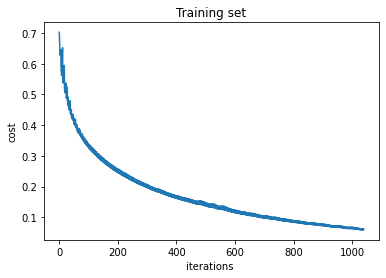

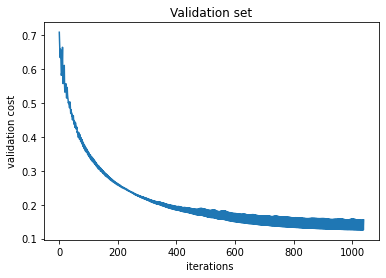

In [24]:
parameters = L_layer_model(train_x, train_y, valid_x, valid_y, layers_dims, learning_rate = 0.009, num_epochs = 40, print_cost = True, batch_size=50)

In [25]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)
predictions_valid = predict(valid_x, valid_y, parameters) 

In [26]:
print("Training Accuracy: ", predictions_train,"%")
print("Testing Accuracy: ", predictions_test,"%")
print("Validation Accuracy: ", predictions_valid,"%")

Training Accuracy:  98.615 %
Testing Accuracy:  94.0 %
Validation Accuracy:  97.0 %
